In [1]:
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.aqua.utils import CircuitFactory
from qiskit.aqua.algorithms import AmplitudeEstimation, FasterAmplitudeEstimation
from qiskit.aqua.components.uncertainty_models import NormalDistribution
from qiskit.quantum_info import Statevector


import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

In [2]:
class BernoulliAFactory(CircuitFactory):
    r"""Circuit Factory representing the operator A in a Bernoulli problem.

    Given a probability $p$, the operator A prepares the state $\sqrt{1 - p}|0> + \sqrt{p}|1>$.
    """

    def __init__(self, probability=0.5):
        #
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))

    def build(self, qc, q, q_ancillas=None, params=None):
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[self.i_state])

    def value_to_estimation(self, value):
        return value

In [3]:
class BernoulliQFactory(CircuitFactory):
    r"""Circuit Factory representing the operator A in a Bernoulli problem.

    Given a probability $p$, the operator A prepares the state $\sqrt{1 - p}|0> + \sqrt{p}|1>$.
    """

    def __init__(self, probability=0.5):
        #
        super().__init__(2)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))

    def build(self, qc, q, q_ancillas=None, params=None):
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(2 * self._theta_p, q[self.i_state])
        
    def build_power(self, qc, q, power, q_ancillas=None):
        qc.ry(2 * power * self._theta_p, q[self.i_state])        

    def value_to_estimation(self, value):
        return value

In [4]:
from qiskit.circuit.library import RYGate

class BernoulliS11QFactory(CircuitFactory):
    r"""Circuit Factory representing the operator A in a Bernoulli problem.

    Given a probability $p$, the operator A prepares the state $\sqrt{1 - p}|0> + \sqrt{p}|1>$.
    """

    def __init__(self, probability=0.5):
        #
        super().__init__(2)
        self._probability = probability
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        
    def required_ancillas(self):
        return 1

    def build(self, qc, q, q_ancillas=None, params=None):
        # A is a rotation of angle theta_p around the Y-axis
        self.build_power(qc, q, 1, q_ancillas)
        
    def build_power(self, qc, q, power, q_ancillas=None):
        qc.ccx(0, 1, 2)
        #qc.cry(2 * power * self._theta_p, 2, 0)
        qc.cry(2 * power * self._theta_p, 2, 1)
        qc.ccx(0, 1, 2)
#         qc.append(RYGate(2 * power * self._theta_p).control(2), [0, 1, 2])
        

    def value_to_estimation(self, value):
        return value

In [85]:
n = 2
#X = NormalDistribution(n, mu=1, sigma=1, low=0, high=2)
y = 0
# a_factory = SingleRV(X, y, 1)
p = (0.176)**2
a_factory = BernoulliAFactory(p)
q_factory = BernoulliQFactory(p)
backend = Aer.get_backend('qasm_simulator')

N = [1000, 1000]
delta = 1 - 0.01
maxiter = 3

print(p)
a = np.sqrt(p)

faster = FasterAmplitudeEstimation(N, delta, maxiter, a_factory, q_factory, i_objective=[0])
#faster._x_factory = a_factory
# faster = FasterAmplitudeEstimation(N, delta, maxiter, a_factory, q_factory)
#faster._x_factory = None



0.030975999999999997


In [91]:
result = faster.run(backend)
result['estimation']

0.0308891684730608

0.03224264518583157

In [8]:
p

0.0576

In [9]:
np.arcsin(p)

0.05763189814265775

In [ ]:
reps = 1000
results = []
maxiters = [2]
for maxiter in maxiters:
    faster = FasterAmplitudeEstimation(N, delta, maxiter, a_factory)
    inside = 0
    for _ in range(reps):
        result = faster.run(backend)
        if result['value_ci'][0] <= p and p <= result['value_ci'][1]:
            inside += 1
    print(N, delta, maxiter, 'confidence:', inside/reps)

In [ ]:
maxiters = list(range(3, 20, 4))
results = []
for maxiter in maxiters:
    faster = FasterAmplitudeEstimation(N, delta, maxiter, a_factory)
    faster._x_factory = None
    result = faster.run(backend)
    results.append(result)
    print(result['value_ci'], result['value_ci'][0] <= p and p <= result['value_ci'][1])

1 -1.9153754392602926
[0.38323556853974877, 1.6793026100265211] True
1 -1.9457796655360402
1 1.8983435390644192
3 -3.070674878630545
5 -0.1305617798610741
10 -0.545211727683385
[0.8698663142448932, 0.9603221347121461] True
1 -1.9656214028218646
1 1.9478723981115798
3 -2.891106491815511
5 0.09990989706871115
10 -0.39667283080928845
20 -1.0973323672040916
40 -2.684324050745464
79 0.44034012848574555
158 0.45192656221409666
[0.9187078852956052, 0.9244233120614351] True
1 -1.9238026095357599
1 1.948718623201206
3 -2.9235098479769226
5 -0.02042991137445622
10 -0.47152712307554084
20 -1.078074129969064
40 -2.6933611551201544
79 0.4125836506259257
158 0.37548068648157323
316 0.39884177383933533
632 0.3960235154840463
1264 0.32913768458642023
2528 0.2215186869294156
[0.9214145854385846, 0.9217719685768764] True
1 -1.9129365048968887
1 1.9495315943515537
3 -2.866566049168211
5 0.04304300967375341
10 -0.3263590248237056
20 -1.0937015806828392
40 -2.6547967721233765
79 0.46000874276787235
158 0.4

In [19]:
print('theta', np.arcsin(0.0563), 'sin(theta)', 0.0563, 'a/4', 0.2 / 4)

theta 0.05632978476122883 sin(theta) 0.0563 a/4 0.05


In [20]:
a = np.sqrt(0.2)

In [21]:
np.sqrt(15 * (1 - a**2)) / 4, np.sqrt(1 - a**2) / 4, np.sqrt(15) * a /4, a / 4

(0.8660254037844386,
 0.22360679774997896,
 0.43301270189221935,
 0.11180339887498948)

In [67]:
p = 0.2
a = np.sqrt(p)
theta = np.arcsin(a / 4)
print(np.sin(theta))
for m in range(1, 4):
    print(m, np.sin((2*m + 1) * theta))

0.11180339887498948
1 0.32982002668121896
2 0.5313456531533876
3 0.7063039969678867


In [62]:
zero = Statevector.from_int(0, dims=(2,2))
three = Statevector.from_int(3, dims=(2,2))

In [64]:
circuit = QuantumCircuit(2)
circuit.ry(2 * np.arcsin(np.sqrt(0.2)), 0)
circuit.ry(2 * np.arcsin(0.25), 1)
Statevector.from_int(0, dims=(2,2)).evolve(circuit) @ three

Statevector([0.       +0.j, 0.       +0.j, 0.       +0.j, 0.1118034+0.j],
            dims=(2, 2))

In [70]:
circuit = QuantumCircuit(3)
circuit.ry(2 * np.arcsin(np.sqrt(0.2)), 0)
circuit.ry(2 * np.arcsin(0.25), 1)
Statevector.from_int(0, dims=(2,2,2)).evolve(circuit)

Statevector([0.8660254+0.j, 0.4330127+0.j, 0.2236068+0.j, 0.1118034+0.j,
             0.       +0.j, 0.       +0.j, 0.       +0.j, 0.       +0.j],
            dims=(2, 2, 2))

In [82]:
zero = Statevector.from_int(0, dims=(2,2,2))
three = Statevector.from_int(3, dims=(2,2,2))


q = QuantumCircuit(3)
q.ccx(0, 1, 2)
q.ry(2 * 2 * np.arcsin(np.sqrt(p)), 2)
# q.cry(2 * 2 * np.arcsin(np.sqrt(0.2)), 2, 1)
q.ccx(0, 1, 2)
zero.evolve(circuit).evolve(q) @ three

Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.06708204+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))

In [23]:
circuit = faster.construct_circuit(0)
circuit.draw()
zero = Statevector.from_int(0, dims=(2,2,2))
three = Statevector.from_int(3, dims=(2,2,2))
zero.evolve(circuit) 
#faster.run(backend)

Statevector([0.6846532+0.j, 0.6846532+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.       +0.j, 0.       +0.j, 0.       +0.j, 0.       +0.j],
            dims=(2, 2, 2))

In [24]:
m = 4
circuit = faster.construct_circuit(m)
circuit.draw()

┌──────────┐       ┌───────────┐  ┌───┐     ┌───┐  ┌──────────┐      »
  q_0: ──┤ RY(pi/2) ├───■───┤ RY(-pi/2) ├──┤ X ├──■──┤ X ├──┤ RY(pi/2) ├───■──»
       ┌─┴──────────┴┐  │  ┌┴───────────┴─┐├───┤  │  ├───┤┌─┴──────────┴┐  │  »
  q_1: ┤ RY(0.50536) ├──■──┤ RY(-0.50536) ├┤ X ├──■──┤ X ├┤ RY(0.50536) ├──■──»
       └────┬───┬────┘┌───┐└──────────────┘└───┘┌─┴─┐├───┤└────┬───┬────┘┌───┐»
aux_0: ─────┤ X ├─────┤ H ├─────────────────────┤ X ├┤ H ├─────┤ X ├─────┤ X ├»
            └───┘     └───┘                     └───┘└───┘     └───┘     └───┘»
«        ┌───────────┐  ┌───┐     ┌───┐  ┌──────────┐       ┌───────────┐  »
«  q_0: ─┤ RY(-pi/2) ├──┤ X ├──■──┤ X ├──┤ RY(pi/2) ├───■───┤ RY(-pi/2) ├──»
«       ┌┴───────────┴─┐├───┤  │  ├───┤┌─┴──────────┴┐  │  ┌┴───────────┴─┐»
«  q_1: ┤ RY(-0.50536) ├┤ X ├──■──┤ X ├┤ RY(0.50536) ├──■──┤ RY(-0.50536) ├»
«       └────┬───┬─────┘└───┘┌─┴─┐├───┤└────┬───┬────┘┌───┐└────┬───┬─────┘»
«aux_0: ─────┤ H ├───────────┤ X ├┤ H ├─────┤ X ├─────┤ X ├─────┤ H ├──────»
«            └───┘           └───┘└───┘     └───┘     └───┘     └───┘      »
«       ┌───┐     ┌───┐  ┌──────────┐       ┌───────────┐  ┌───┐     ┌───┐»
«  q_0: ┤ X ├──■──┤ X ├──┤ RY(pi/2) ├───■───┤ RY(-pi/2) ├──┤ X ├──■──┤ X ├»
«       ├───┤  │  ├───┤┌─┴──────────┴┐  │  ┌┴───────────┴─┐├───┤  │  ├───┤»
«  q_1: ┤ X ├──■──┤ X ├┤ RY(0.50536) ├──■──┤ RY(-0.50536) ├┤ X ├──■──┤ X ├»
«       └───┘┌─┴─┐├───┤└────┬───┬────┘┌───┐└────┬───┬─────┘└───┘┌─┴─┐├───┤»
«aux_0: ─────┤ X ├┤ H ├─────┤ X ├─────┤ X ├─────┤ H ├───────────┤ X ├┤ H ├»
«            └───┘└───┘     └───┘     └───┘     └───┘           └───┘└───┘»
«         ┌──────────┐ 
«  q_0: ──┤ RY(pi/2) ├─
«       ┌─┴──────────┴┐
«  q_1: ┤ RY(0.50536) ├
«       └────┬───┬────┘
«aux_0: ─────┤ X ├─────
«            └───┘

In [25]:
zero.evolve(circuit) @ three 

Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.99959107+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))

In [26]:
print('sin(2m + 1)theta', np.sin((2 * m + 1) * np.arcsin(a / 4)))

sin(2m + 1)theta 0.8459471409339914


In [41]:
widths = [np.diff(result['value_ci'])[0] / 2 for result in results]
oracle_calls = [result['num_oracle_calls'] for result in results]

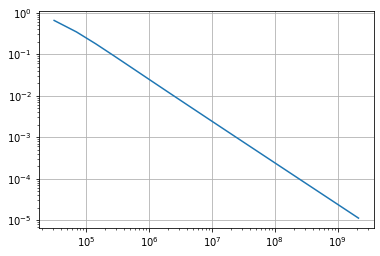

In [42]:
plt.loglog(oracle_calls, widths)
plt.grid()

In [84]:
from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
circuit = QuantumCircuit(3)
a, t = Parameter('alpha'), Parameter('theta')

circuit.ry(2 * t, 0)
circuit.ry(2 * a, 1)
circuit.x([0, 1, 2])
circuit.h(2)
circuit.ccx(0, 1, 2)
circuit.h(2)
circuit.x([0, 1, 2])
circuit.ry(-2 * t, 0)
circuit.ry(-2 * a, 1)
circuit.cz(0, 1)

In [85]:
transpiled = transpile(circuit, optimization_level=3)

In [86]:
transpiled.draw()

┌─────────────┐┌───┐     ┌───┐┌──────────────┐   
q_0: ┤ RY(2*theta) ├┤ X ├──■──┤ X ├┤ RY(-2*theta) ├─■─
     ├─────────────┤├───┤  │  ├───┤├──────────────┤ │ 
q_1: ┤ RY(2*alpha) ├┤ X ├──■──┤ X ├┤ RY(-2*alpha) ├─■─
     └────┬───┬────┘├───┤┌─┴─┐├───┤└────┬───┬─────┘   
q_2: ─────┤ X ├─────┤ H ├┤ X ├┤ H ├─────┤ X ├─────────
          └───┘     └───┘└───┘└───┘     └───┘